<a href="https://colab.research.google.com/github/jiiwon129/ESAA/blob/main/ESAA_WEEK6_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **[ 개념정리 ]**

**07 LightGBM**

---

- XGBoost보다 학습에 걸리는 시간이 적음
- 메모리 사용량도 상대적으로 적음

-> 하지만 XGBoost와 예측 성능에서 별 차이가 X

[ 단점 ]
- 적은 데이터 세트에 적용할 경우 Overfitting(과적합)의 가능성이 높음 (일반적으로 10,000건 이하의 데이터 세트)

- 리프 중심 트리 분할(Leaf Wise) 방식 사용
  - 일반 GBM 계열의 트리 분할 방법과 다름
  - 트리의 균형을 맞추는 데에 시간을 쓰지 않음
  - 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할 -> 트리의 깊이가 깊어지고 비대칭적 규칙 트리 생성
  
  -> 균형 트리 분할 방식(일반적인 트리 분할 방식)보다 예측 오류 손실을 최소화

  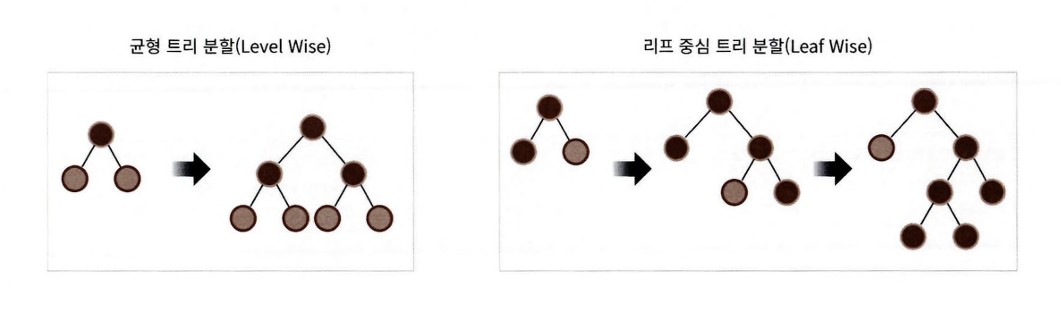

```
import lightgbm
from lightgbm import LGBMClassifier
```

**LightGBM 하이퍼 파라미터**
- num_iterations (default=100): 반복 수행하려는 트리의 개수
- learning_rate (default=0.1): 학습률
- max_depth (default=-1): 트리 기반 알고리즘의 max depth와 동일
  - 0보다 작은 값으로 지정 시 깊이에 제한 X
- min_data_in_leaf (default=20): 결정 트리의 min_samples_leaf와 동일
- num_leaves (default=31): 하나의 트리가 가질 수 있는 최대 leaf 개수
- boosting (defaul=gbdt): 부스팅의 트리를 생성하는 알고리즘
  - gbdt: 일반적 그래디언트 부스팅 결정 트리
  - rf: 랜덤 포레스트
- bagging_fraction (default=1.0): 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율(과적합을 막기 위함)
  - XGBClassifier의 colsample_bytree와 동일
  - LightGBM Classifier에서도 comsample_bytree로 사용
- lambda_l2 (default=0.0): L2 regulation 제어를 위한 값
- lambda_l1 (default=0.0): L1 regualtion 제어를 위한 값

Learning Task 파라미터
- objective: 최솟값을 가져야 할 손실함수(loss function) 정의
  - XGBoost의 objective parameter와 동일

**하이퍼 파라미터 튜닝 방안**
- num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함꼐 조정 -> 모델의 복잡도 감소

  - **num_leaves** 증가 -> 정확도 증가, but 트리의 깊이가 깊어지고 모델의 복잡도 증가로 Overfitting 가능성 증가
  - **min_data_in_leaf** 증가 -> 보통 트리가 깊어지는 것을 방지
  - **max_depth** -> 깊이의 크기를 제한

+ learning_rate 감소, n_estimators 증가 (가장 기본적인 튜닝 방안)

  -> n_estimators를 너무 크게 지정할 시에 Overfitting 가능성 증가

**파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교**

- 사이킷런 래퍼 LightGBM 클래스와 사이킷런 래퍼 XGBoost 클래스는 많은 하이퍼 파라미터가 동일함

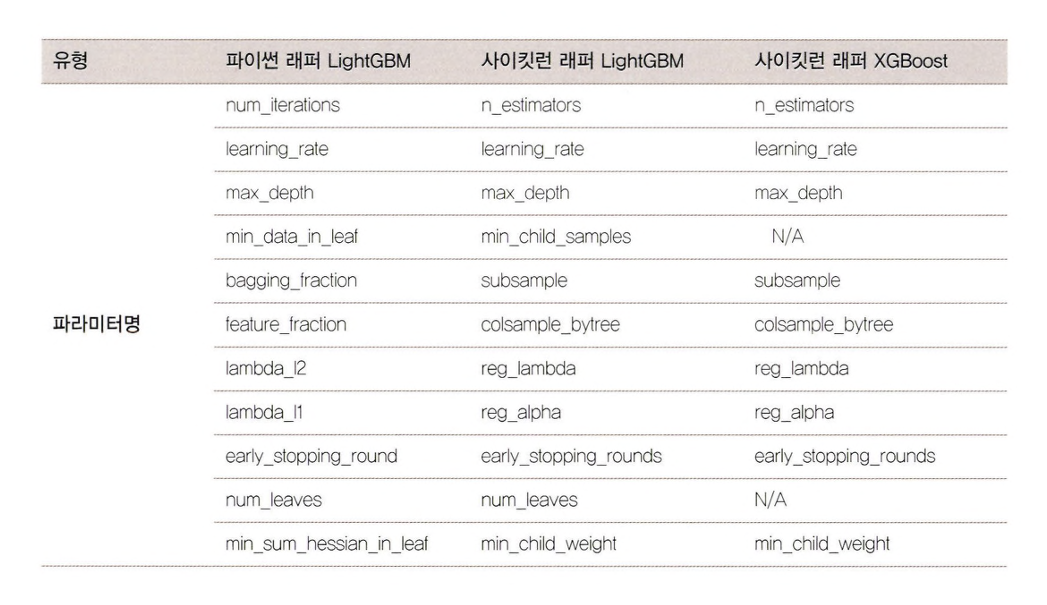

**LightGBM 적용 - 위스콘신 유방암 예측**

---

- 조기 중단 가능(early stopping)
  - LGBMClassifier()에 early_stopping_rounds parameter 설정
  - XGBClassifier와 동일

```
# 전체 데이터에서 학습/테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size,random_state)

# X_train, y_train을 다시 split해서 학습/테스트용 데이터 추출
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size,random_state)
```

- 피처 중요도 시각화
  - XGBoost와 동일

```
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm.wrapper,ax=ax)
```

**08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**

---

Grid Search
- 튜닝해야 할 하이퍼 파라미터 값의 개수가 많을 경우 최적화 수행 시간이 오래 걸림

-> 베이지안 최적화 기법 사용

**베이지안 최적화**
- **목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수**에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방법
- 즉, **f(x,y)의 반환값을 최대/최소로 하는 x,y 값을 찾아냄**

< Step1 >
- 최초엔 랜덤하게 하이퍼 파라미터들을 샘플링 후 성능 관측
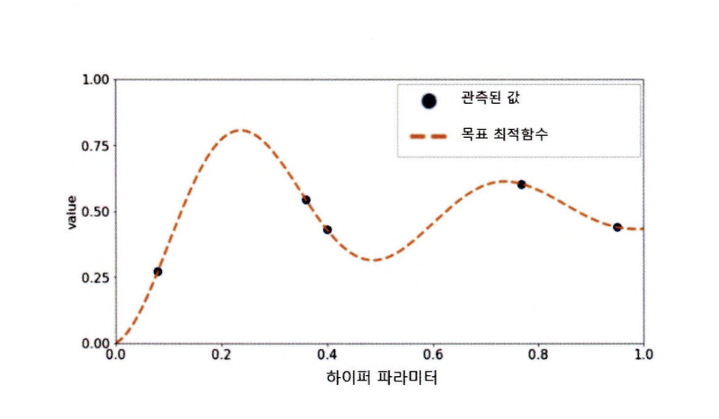



< Step2 >
- 관측된 값을 기반으로 대체 모델은 최적 함수를 추정
- 파란색 실선: 대체 모델이 추정한 최적 함수
- 최적 관측값: y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터
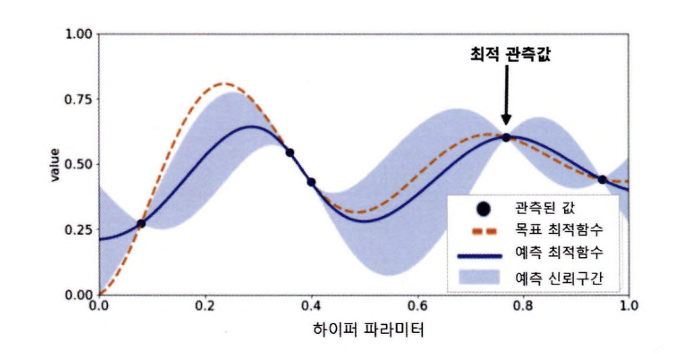

< Step3 >
- 추정된 최적 함수를 기반으로 획득 함수(Acquisition Function)는 다음으로 관측할 하이퍼 파라미터 값을 계산
- 획득 함수: 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달

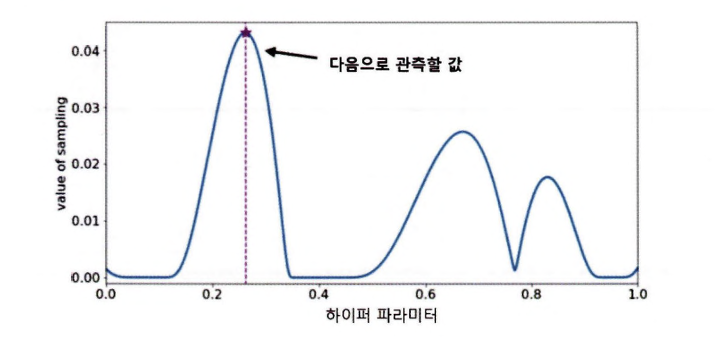

< Step4 >
- 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델 갱신

-> 다시 최적 함수를 예측 추정

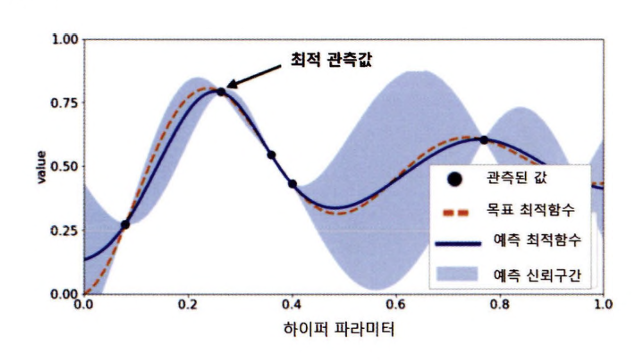

이런 방식으로 Step3, Step4를 반복하여 대체 모델의 불확실성 개선, 정확한 최적 함수 추정 가능


**HyperOpt 사용하기**

1. 입력 변수명과 입력값의 검색 공간(Search Space) 설정
2. 목적 함수(Objective Function)의 설정
3. 목적 함수의 반환 최적 최솟값을 유추
---

(1) 입력 변수명, 입력값 검색 공간: 딕셔너리 형태로 설정
  - key: 입력 변수명
  - value: 입력값 검색 공간

```
from hyperopt import hp

search_space={'x':hp.quniform('x',-10,10,1),
              'y':hp.quniform('y',-15,15,1)}
```

- hp.quiform(label,low,high,q): search_space를 low에서 high까지 q의 간격으로 설정
- hp.uniform(label,low,high): low부터 high까지 정규 분포 형태의 search space 설정
- hp.randint(label,upper): 0부터 upper까지 random한 정숫값으로 설정
- hp.loguniform(label,low,high): exp(uniform(low,high)) 값 반환 -> log 변환된 값은 정규 분포 형태를 가지는 search space 설정
- hp,choice(label,options): 검색 값이 문자열 또는 숫자값이 같이 섞여 있을 경우 설정
---
(2) 목적 함수 생성
- 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받음
- 특정 값을 반환하는 구조
  - 숫자형 단일값 외에도 딕셔너리 형태로 반환 가능 -> {'loss':retval, 'status':STATUS_OK} 와 같이 loss와 status 키 값을 설정 후 반환해야함

```
from hyperopt import STATUS_OK

def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval=x**2-2-*y
  
  return retval
```
---
(3) 최적값 유추

fmin(objective, space, algo, max_evals, trials)

- fn: 목적 함수
- space: 검색 공간 딕셔너리
- algo: 베이지안 최적화 적용 알고리즘
  - 기본적으로 tpe.suggest
- max_evals: 입력값 시도 횟수
- trials: 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장
  - Trials()
- rstate: 랜덤 시드

```
from hyperopt import fmin,tpe,Trials

trial_val = Trials()

best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_eval=5, trials=trial_val, rstate=np.random.default_rng(seed=0))

best_01 # object_func의 최솟값을 반환하는 최적 입력 변숫값
```
---
Trials()
- 함수의 반복 수행 시마다 입력되는 변숫값들과 함수 반환값을 속성으로 가짐
- Trials().results
  - 반복 수행 시마다 반환되는 반환값
  - {'loss':함수 반환값,'status':반환 상태값}
- Trials().vals
  - 함수의 반복 수행 시마다 입력되는 입력 변숫값
  - {'입력변수명': 개별 수행 시마다 입력된 값 리스트}

**HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화**

---

HyperOpt

(1) 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값

-> XGBoostClassifier의 정수형 하이퍼 파라미터값으로 설정할 때는 정수형으로 형변환

(2) HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야 함

-> 값이 클수록 좋은 성능 지표일 경우 -1을 곱한 뒤 반환 (ex) 정확도

```
def objective_func(search_space)：
  xgb_clf = XGBClassifier(n_estimators=100,  
    max_depth=int(search_space[‘max_depth']),
    min_child_weight=int(search_space['min_child_weight']),
    learning_rate=search_space['learning_rate'],
    colsample_bytree=search_space['colsample_bytree'],
    eval_metric='logloss')
 accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

 # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
 return {'loss’：-1 * np.mean(accuracy), 'status'： STATUS_OK}
 ```


**11 스태킹 앙상블**

---

개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출하는 방법
- 배깅(Bagging), 부스팅(Boosting)과 공통점
  - But 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 차이점

메타 모델
- 개별 모델의 예측 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식

[ 필요한 모델 ]

(1) 개별적 기반 모델

(2) 최종 메타 모델
- 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 모델

**여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것**

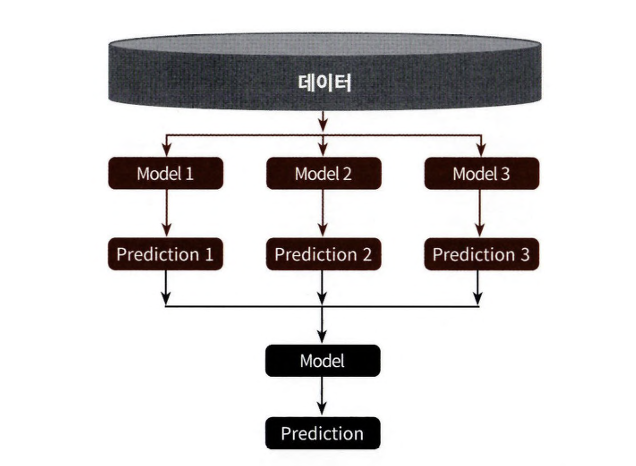

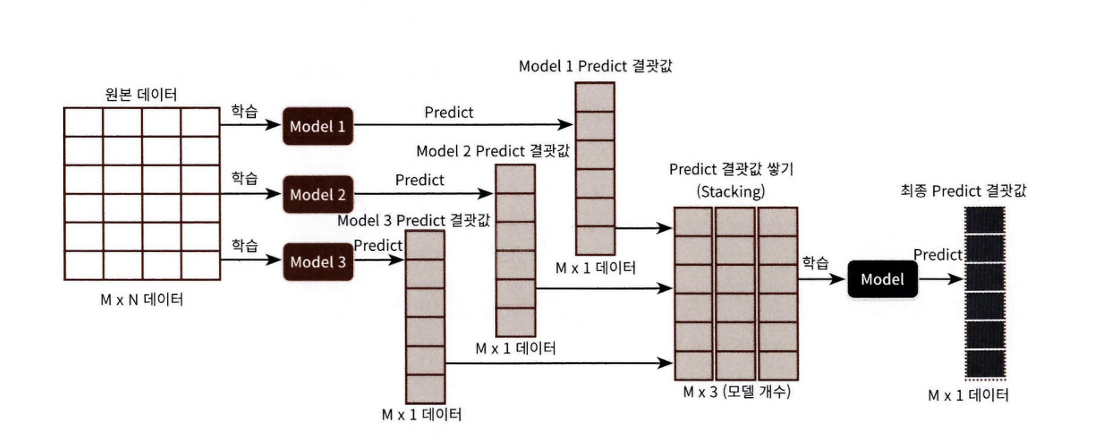

**CV 세트 기반의 스태킹**
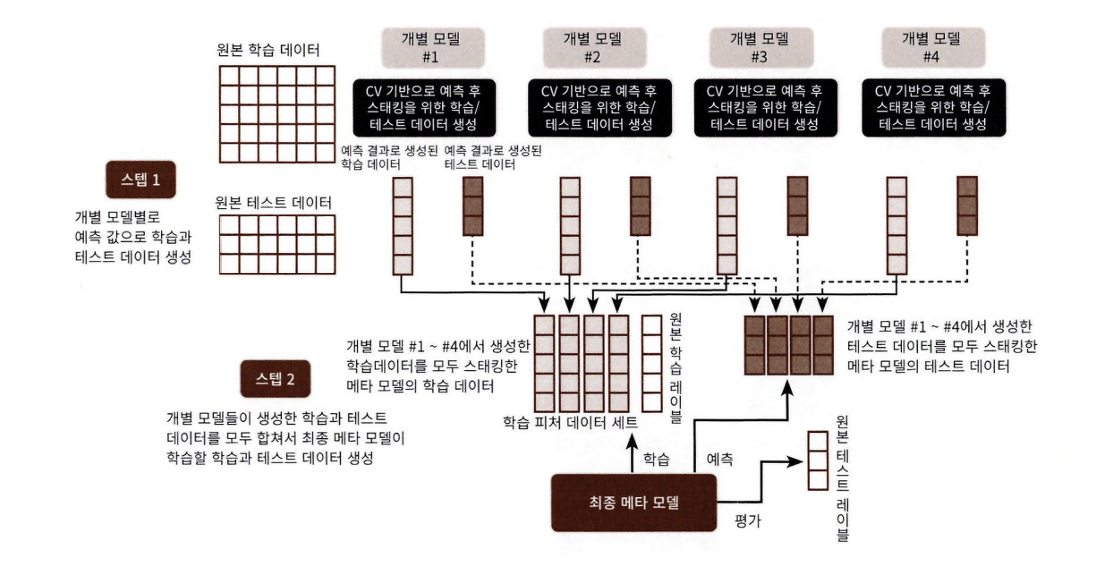

< Step1 >

개별 모델 레벨에서 수행하여 이 로직을 여러 개의 개별 모델에서 동일하게 수행
- 학습용 데이터를 N개의 폴드로 나눔
- N번의 유사한 반복 작업을 수행하고, 마지막 N번째 반복에서 개별 모델의 예측 값으로 학습 데이터와 테스트 데이터 생성
  - 이렇게 만들어진 예측 데이터는 **메타 모델을 학습시키는 학습 데이터로 사용**
- (N-1)개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값 생성
  - 이 로직을 N번 반복하며 이 예측값들의 평균으로 최종 결과값 생성
    - 이를 **메타 모델을 위한 테스트 데이터로 사용**

< Step2 >

각 모델들이 Step1로 생성한 학습/테스트 데이터를 모두 합쳐 최종적으로 메타 모델이 사용할 학습/테스트 데이터 생성
- 이 데이터로 메타 모델 학습 후 최종 테스트 데이터로 예측 수행
  - 이 결과를 원본 테스트 데이터의 레이블 데이터와 비교 및 평가

```
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  # 지정된 n_folds값으로 KFold 생성.
  kf=KFold(n_splits=n_folds,shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:',folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr,y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델의 학습 수행.
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:,folder_counter]=model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred,test_pred_mean
```

**12 분류 정리**

---

앙상블(Ensemble) 기법
- 대부분은 결정 트리 기반의 다수의 약한 학습기를 결합해 변동성을 줄여 예측 오류를 줄이고 성능을 개선함
  - 정보의 균일도에 기반한 규칙 트리 생성 후 예측 수행
  - 균일한 최종 예측 결과 도출을 위해 결정 트리가 깊어지고 복잡해지며 Overfitting 쉽게 발생

- 대표적으로 배깅(Bagging)과 부스팅(Boosting)

- 배깅(Bagging): 학습 데이터를 중복 허용, 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합하여 예측
  - ex) Random Forest

- 부스팅(Boosting): 학습기들이 순차적으로 학습을 진행하며 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때, 이전에 예측이 틀린 데이터에 대해 높은 정확도로 예측할 수 있도록 함
  - ex) Gradient Boosting

- XGBoost, LightGBM

- 스태킹 모델: 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재생성하는 기법
  - 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태킹 형태로 결합해 생성하는 것이 핵심!


### **[ 필사 ]**

In [ ]:
!pip install scikit-learn==1.2.2
!pip install xgboost==1.7.6

#### **07 LightGBM**

LightGBM 설치

In [1]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [2]:
import lightgbm
from lightgbm import LGBMClassifier

LightGBM 적용 - 위스콘신 유방암 예측

In [5]:
# LightGBM의 파이썬 패키지인 lightgmb에서 LGBMClassifier import
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()

cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10% 검증용 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400,learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric="logloss",
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [7]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc=roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [8]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

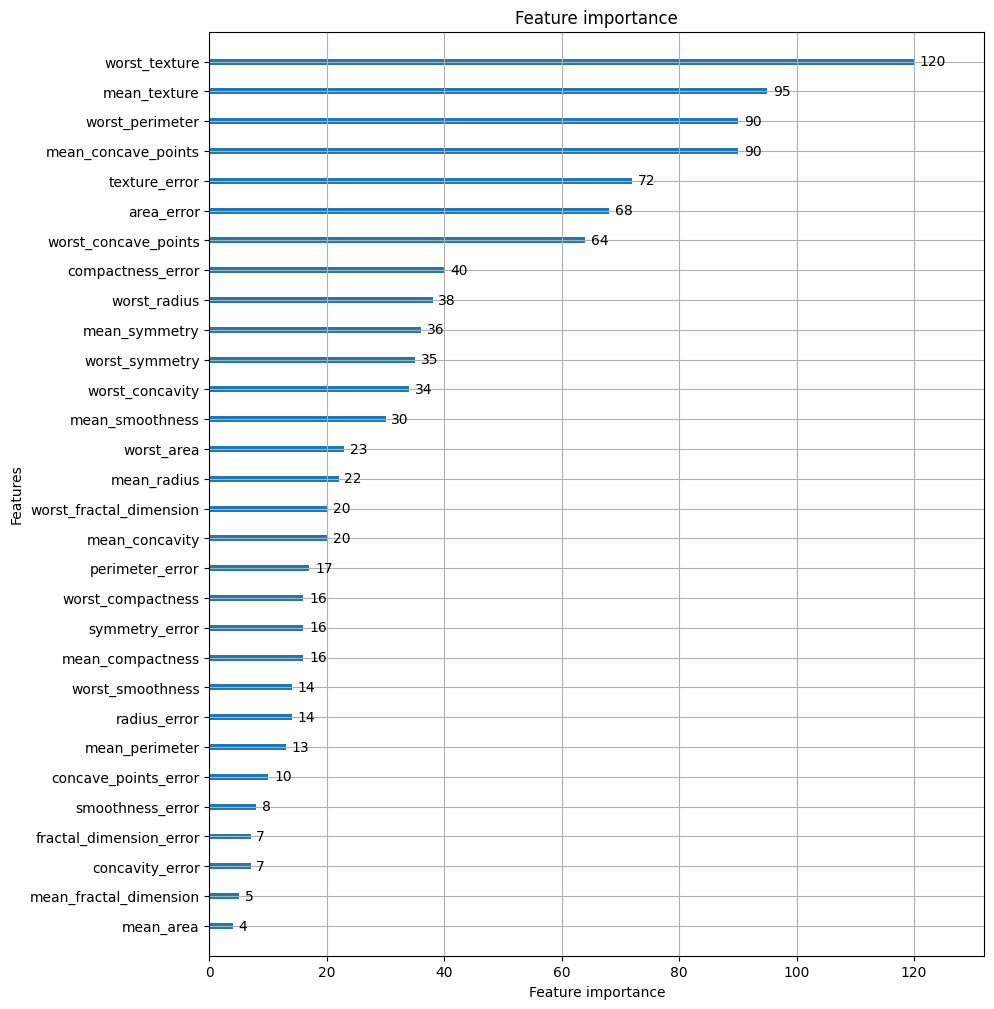

In [9]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

**08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**

In [10]:
params={
    'max_depth':[10,20,30,40,50],
    'num_leaves':[35,45,55,65],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],
    'subsample':[0.5,0.6,0.7,0.8,0.9],
    'min_child_weight':[10,20,30,40],
    'reg_alpha':[0.01,0.05,0.1]
    }

**HyperOpt 사용하기**

In [12]:
!pip install hyperopt

In [13]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
search_space={
    'x':hp.quniform('x',-10,10,1),
    'y':hp.quniform('y',-15,15,1)
}

In [17]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
  x=search_space['x']
  y=search_space['y']
  retval=x**2-20*y

  return retval

In [18]:
from hyperopt import fmin,tpe,Trials
# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val=Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01=fmin(fn=objective_func,
             space=search_space,
             algo=tpe.suggest,
             max_evals=5,
             trials=trial_val,
             rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|██████████| 5/5 [00:00<00:00, 635.98trial/s, best loss: -224.0]
best: {'x': np.float64(-4.0), 'y': np.float64(12.0)}


In [23]:
trial_val=Trials()

# max_evals를 20회로 늘려서 재테스트
best_02=fmin(fn=objective_func,
             space=search_space,
             algo=tpe.suggest,
             max_evals=20,
             trials=trial_val,
             rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|██████████| 20/20 [00:00<00:00, 554.19trial/s, best loss: -296.0]
best: {'x': np.float64(2.0), 'y': np.float64(15.0)}


In [26]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값,'status':반환 상태값}와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [27]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [np.float64(-6.0), np.float64(-4.0), np.float64(4.0), np.float64(-4.0), np.float64(9.0), np.float64(2.0), np.float64(10.0), np.float64(-9.0), np.float64(-8.0), np.float64(-0.0), np.float64(-0.0), np.float64(1.0), np.float64(9.0), np.float64(6.0), np.float64(9.0), np.float64(2.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-0.0)], 'y': [np.float64(5.0), np.float64(10.0), np.float64(-2.0), np.float64(12.0), np.float64(1.0), np.float64(15.0), np.float64(7.0), np.float64(-10.0), np.float64(0.0), np.float64(-5.0), np.float64(-3.0), np.float64(2.0), np.float64(4.0), np.float64(10.0), np.float64(3.0), np.float64(3.0), np.float64(-14.0), np.float64(-8.0), np.float64(11.0), np.float64(-0.0)]}


In [28]:
import pandas as pd

# results에서 loss 키값에 해당하는 values를 추출하여 list로 생성.
losses=[loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df=pd.DataFrame({
    'x':trial_val.vals['x'],
    'y':trial_val.vals['y'],
    'losses':losses
})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [29]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()

cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,
                                               random_state=156)

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

In [30]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space={'max_depth':hp.quniform('max_depth',5,20,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

※ XGBClassifier에 정수형 하이퍼 파라미터 입력 시 정수형으로 명시적 형변환 수행

※ 목적 함수의 최종 반환 값이 교차 검증 평균 정확도에 -1을 곱해야 함

In [35]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도(Accuracy)를 곱해서 큰 정확도 값일수록 최소가 되도록 반환

def objective_func(search_space):
  # 수행 시간 절약을 위해 n_estimators는 100으로 축소
  xgb_clf=XGBClassifier(n_estimators=100,
                        max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        learning_rate=search_space['learning_rate'],
                        colsample_bytree=search_space['colsample_bytree'],
                        eval_metric='logloss')
  accuracy=cross_val_score(xgb_clf,X_train,y_train,scoring='accuracy',cv=3)

  # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
  return {'loss':-1*np.mean(accuracy),'status':STATUS_OK}

In [36]:
from hyperopt import fmin,tpe,Trials

trial_val=Trials()
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수 지정
          trials=trial_val,
          rstate=np.random.default_rng(seed=9))
print('best:',best)

100%|██████████| 50/50 [00:19<00:00,  2.51trial/s, best loss: -0.9692256303009179]
best: {'colsample_bytree': np.float64(0.5461694564507846), 'learning_rate': np.float64(0.19273232099361282), 'max_depth': np.float64(14.0), 'min_child_weight': np.float64(2.0)}


정수형 하이퍼 파라미터인 max_depth, min_child_weight가 실수형 값으로 도출됨

In [37]:
print('colsample_bytree:{0}, learning_rate:{1},max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'],5),round(best['learning_rate'],5),
    int(best['max_depth']), int(best['min_child_weight']) # 정수형 변환
))

colsample_bytree:0.54617, learning_rate:0.19273,max_depth:14, min_child_weight:2


도출된 하이퍼 파라미터를 이용하여 XGBClassifier 재학습 후 성능 평가

In [46]:
xgb_wrapper=XGBClassifier(n_estimators=400,
                          learning_rate=round(best['learning_rate'],5),
                          max_depth=int(best['max_depth']),
                          min_child_weight=int(best['min_child_weight']),
                          colsample_bytree=round(best['colsample_bytree'],5),
                          eval_metric='logloss',early_stopping_rounds=50)
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,eval_set=evals,verbose=True)
preds=xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test,preds,pred_proba)

[0]	validation_0-logloss:0.51859	validation_1-logloss:0.55086
[1]	validation_0-logloss:0.41584	validation_1-logloss:0.48070
[2]	validation_0-logloss:0.34064	validation_1-logloss:0.42700
[3]	validation_0-logloss:0.28358	validation_1-logloss:0.38521
[4]	validation_0-logloss:0.23855	validation_1-logloss:0.34738
[5]	validation_0-logloss:0.20443	validation_1-logloss:0.32379
[6]	validation_0-logloss:0.17539	validation_1-logloss:0.30681
[7]	validation_0-logloss:0.15371	validation_1-logloss:0.29695
[8]	validation_0-logloss:0.13470	validation_1-logloss:0.28727
[9]	validation_0-logloss:0.12077	validation_1-logloss:0.28369
[10]	validation_0-logloss:0.10750	validation_1-logloss:0.27569
[11]	validation_0-logloss:0.09655	validation_1-logloss:0.27134
[12]	validation_0-logloss:0.08809	validation_1-logloss:0.26722
[13]	validation_0-logloss:0.08068	validation_1-logloss:0.26347
[14]	validation_0-logloss:0.07474	validation_1-logloss:0.26178
[15]	validation_0-logloss:0.06786	validation_1-logloss:0.26060
[1

**11 스태킹 앙상블**

기본 스태킹 모델

In [47]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,test_size=0.2,
                                               random_state=0)

개별 모델: KNN, Random Forest, Decision Tree, AdaBoost

최종 모델: Logistic Regression

In [48]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression()

In [49]:
# 개별 모델들을 학습.
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [50]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('Random Forest 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('Decision Tree 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('AdaBoost 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
Random Forest 정확도: 0.9649
Decision Tree 정확도: 0.9123
AdaBoost 정확도: 0.9737


In [51]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. column level로 각 알고리즘의 prediction 결과를 feature로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [52]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도: 0.9737


Step1

In [56]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  # 지정된 n_folds값으로 KFold 생성.
  kf=KFold(n_splits=n_folds,shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0],1))
  test_pred=np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트:',folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr,y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델의 학습 수행.
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:,folder_counter]=model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred,test_pred_mean

In [63]:
knn_train,knn_test=get_stacking_base_datasets(knn_clf,X_train,y_train,X_test,7)
rf_train,rf_test=get_stacking_base_datasets(rf_clf,X_train,y_train,X_test,7)
dt_train,dt_test=get_stacking_base_datasets(dt_clf,X_train,y_train,X_test,7)
ada_train,ada_test=get_stacking_base_datasets(ada_clf,X_train,y_train,X_test,7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [64]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 데이터 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 데이터 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [65]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
